# VeronaCard Next‑POI Prediction – Metrics & Exploratory Analysis

*Generated automatically on 2025-06-25 13:01 UTC*

# 🎯 Obiettivi dell'Analisi

Questo notebook fornisce una **valutazione completa** delle performance del modello di predizione next-POI implementato in `veronacard_mob.py`, attraverso un framework di analisi strutturato e riproducibile.

## 📋 Pipeline di Analisi

### 🔄 **1. Data Loading & Preprocessing**
- **Caricamento automatico** di tutti i file CSV di predizione (`*_pred_*.csv`)
- **Parsing robusto** con gestione errori per file malformati
- **Estrazione automatica** dell'anno dai nomi file (es. `dati_2016_pred_model.csv` → 2016)
- **Validazione** delle predizioni (filtro per liste con esattamente 5 elementi)

### 📊 **2. Evaluation Metrics**
Calcolo di **quattro metriche standard** per sistemi di raccomandazione:
- **🎯 Top-1 Accuracy**: Precisione della predizione principale
- **📈 Top-5 Hit Rate**: Presenza del POI corretto nella top-5
- **⚡ Mean Reciprocal Rank (MRR)**: Qualità del ranking delle predizioni
- **🗂️ Catalogue Coverage**: Diversità delle raccomandazioni

### 📈 **3. Multi-level Visualization**
- **📊 Global metrics**: Performance aggregate su tutto il dataset
- **📅 Temporal analysis**: Trend evolutivo per anno (2016→2020)
- **🎨 Interactive charts**: Grafici comparativi e heat-maps

### 🔍 **4. Advanced Error Analysis Framework**
Sistema modulare ed estendibile per analisi approfondita:
- **🚨 Worst-case analysis**: Identificazione delle coppie POI più problematiche
- **🔥 Confusion matrices**: Visualizzazione degli errori sui POI più frequenti
- **🧠 Explainability**: Analisi dei pattern testuali che causano errori (LIME/SHAP-ready)
- **📊 Temporal patterns**: Analisi stagionale e trend temporali degli errori

## 🏗️ Caratteristiche Architetturali

### **✅ Robustezza**
- **Error handling** completo per file CSV corrotti
- **Graceful degradation** per dipendenze mancanti (LIME, etc.)
- **Validation** automatica dei dati di input

### **🔧 Flessibilità**
- **Path-agnostic**: Funziona con CSV nella cartella corrente o tramite `DATA_DIR`
- **Modular design**: Sezioni indipendenti eseguibili singolarmente
- **Extensible framework**: Facile aggiungere nuove metriche o analisi

### **📊 Riproducibilità**
- **Timestamp automatico** nel titolo
- **Seed fisso** per operazioni random
- **Versioning implicito** tramite nomi file con data

---

## 🚀 Quick Start

```python
# Esecuzione standard - CSV nella cartella 'results/'
# Nessuna configurazione richiesta

# Esecuzione personalizzata
DATA_DIR = "/path/to/your/csv/files"  # opzionale
```

## 📁 Struttura File Attesa

```
project_root/
├── notebook.ipynb           # questo notebook
├── results/                 # directory predefinita
│   ├── dati_2016_pred_model1.csv
│   ├── dati_2017_pred_model1.csv
│   └── ...
└── veronacard_mob.py       # script di generazione predizioni
```

---

> **💡 Pro Tip**: Il notebook è progettato per **fail-safe operation** — anche se alcuni file sono corrotti o alcune librerie mancano, l'analisi procede con le parti disponibili e fornisce sempre risultati utili.

In [23]:

from pathlib import Path
import ast
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True


## 1. Load data

In [24]:
from pathlib import Path
import glob, ast, os
import numpy as np
import pandas as pd

# Percorso ai file CSV
csv_files = [Path(p) for p in glob.glob(os.path.join('../results', '*_pred_*.csv'))]
csv_files = sorted(csv_files)
assert csv_files, "No CSV files matching *_pred_*.csv found!"

dfs = []
for fp in csv_files:
    try:
        df = pd.read_csv(fp)
    except pd.errors.ParserError:
        print(f"Warning: Parser error in {fp}, trying with error handling...")
        df = pd.read_csv(fp, on_bad_lines='skip', engine='python')

    # Estrai l'anno dal nome file, es. dati_2016_pred_...
    year_token = next((part for part in fp.stem.split('_')
                       if part.isdigit() and len(part) == 4), None)
    df['year'] = int(year_token) if year_token else np.nan

    df['prediction_list'] = df['prediction'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else []
    )
    df = df[df['prediction_list'].apply(len) == 5]
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(df_all):,} rows from {len(csv_files)} files")
df_all.head()


Loaded 119,720 rows from 13 files


,card_id,cluster,history,current_poi,prediction,ground_truth,reason,hit,year,prediction_list
0,0400018ABF3185,6.0,"['Arena', 'Tomba Giulietta', 'Torre Lamberti',...",Duomo,"['Palazzo della Ragione', 'Museo Miniscalchi',...",Castelvecchio,Considerando le attrazioni già visitate (Arena...,False,2014,"[Palazzo della Ragione, Museo Miniscalchi, Cas..."
1,0400038ABF3185,0.0,"['Arena', 'Torre Lamberti', 'Casa Giulietta', ...",Palazzo della Ragione,"['Museo Storia', 'Verona Tour', 'Giardino Gius...",Castelvecchio,La scelta dei POI più probabili è stata effett...,False,2014,"[Museo Storia, Verona Tour, Giardino Giusti, S..."
2,040005523F3885,1.0,"['Casa Giulietta', 'Arena', 'Castelvecchio', '...",Duomo,"['Palazzo della Ragione', 'Museo Miniscalchi',...",Santa Anastasia,Questi punti di interesse sono vicini al clust...,True,2014,"[Palazzo della Ragione, Museo Miniscalchi, San..."
3,040006523F3885,6.0,"['Castelvecchio', 'San Zeno', 'Duomo']",Teatro Romano,"['Palazzo della Ragione', 'Museo Conte', 'Casa...",Santa Anastasia,Sono stati scelti i POI che sono in prossimità...,False,2014,"[Palazzo della Ragione, Museo Conte, Casa Giul..."
4,040007523F3885,1.0,"['Arena', 'Castelvecchio', 'Casa Giulietta', '...",Santa Anastasia,"['Museo Miniscalchi', 'Giardino Giusti', 'Duom...",Duomo,Le distanze indicate sono relativamente brevi ...,True,2014,"[Museo Miniscalchi, Giardino Giusti, Duomo, Te..."


# 2. Definizione delle Metriche di Valutazione

Per valutare le performance del modello di predizione next-POI, utilizziamo quattro metriche standard nel campo dei sistemi di raccomandazione e della predizione sequenziale.

## Notazione

Sia $y_i$ il vero next-POI (ground truth) per la sequenza $i$-esima, e sia $\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}$ la lista **ordinata** delle $k$ raccomandazioni prodotte dal modello per quella sequenza, dove $\hat{y}_i^{(1)}$ è la predizione con confidence più alta.

---

## 📊 Top-1 Accuracy

Misura la **precisione della predizione principale** del modello.

$$\text{Acc}_{@1} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}\!\left\{y_i = \hat{y}_i^{(1)}\right\}$$

**Interpretazione**: Percentuale di casi in cui la prima predizione del modello coincide esattamente con il POI realmente visitato.

**Range**: [0, 1], dove 1 = predizione perfetta

---

## 🎯 Top-k Hit Rate

Misura se il POI corretto è presente **tra le prime $k$ predizioni**.

$$\text{HR}_{@k} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}\!\left\{y_i \in \{\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}\}\right\}$$

**Interpretazione**: Percentuale di casi in cui il POI corretto è presente nella lista delle prime $k$ raccomandazioni. Per $k=5$: "Il modello include il POI corretto nella sua top-5?"

**Range**: [0, 1], sempre $\text{HR}_{@k} \geq \text{Acc}_{@1}$

---

## ⚡ Mean Reciprocal Rank (MRR)

Considera sia la **presenza** del POI corretto nella lista che la sua **posizione**.

$$\text{MRR} = \frac{1}{N}\sum_{i=1}^{N}\frac{1}{\text{rank}_i}$$

dove $\text{rank}_i = \min\{r \mid y_i = \hat{y}_i^{(r)}\}$ è la posizione del POI corretto nella lista ordinata.

**Interpretazione**: 
- Se il POI corretto è al 1° posto → contributo = 1.0
- Se il POI corretto è al 2° posto → contributo = 0.5  
- Se il POI corretto è al 5° posto → contributo = 0.2
- Se il POI corretto non è nella top-k → contributo = 0.0

**Range**: [0, 1], dove valori più alti indicano che i POI corretti appaiono nelle prime posizioni

---

## 🗂️ Catalogue Coverage  

Misura la **diversità** delle raccomandazioni prodotte dal modello.

$$\text{Coverage} = \frac{\left|\bigcup_{i=1}^{N}\{\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}\}\right|}{|\mathcal{P}|}$$

dove $\mathcal{P}$ è l'insieme completo dei POI presenti nel dataset (ground truth).

**Interpretazione**: Frazione dei POI disponibili che il modello è in grado di raccomandare. 
- Coverage = 1.0: il modello raccomanda tutti i POI del catalogo
- Coverage = 0.1: il modello raccomanda solo il 10% dei POI disponibili

**Importanza**: Previene il bias verso POI molto popolari e garantisce diversità nelle raccomandazioni.

---

## 💡 Note Metodologiche

- **$N$**: Numero totale di predizioni nel dataset di test
- **$k = 5$**: Utilizziamo consistently una finestra di 5 raccomandazioni
- **Ordinamento**: Le predizioni sono ordinate per confidence/probabilità decrescente
- **Handling missing**: Se $y_i \notin \{\hat{y}_i^{(1)}, \ldots, \hat{y}_i^{(k)}\}$, contributo = 0 per tutte le metriche

Queste metriche forniscono una **valutazione completa** del modello: precision (Acc@1), recall (HR@k), ranking quality (MRR), e diversity (Coverage).

### 2.1 Helper functions & per‑row computations

In [25]:
import json

def poi_id(x):
    """
    Converte 'x' in un identificatore hashable comparabile con ground-truth.
    • Se x è un dict          → prova a usare 'poi', 'poi_id', 'name', 'id'
    • Se x è list/tuple       → ritorna tupla ricorsiva
    • Altrimenti (str/int)    → cast a str
    """
    if isinstance(x, dict):
        for key in ('poi', 'poi_id', 'name', 'id'):
            if key in x:
                return str(x[key])
        # fallback: serializza in JSON ordinato
        return json.dumps(x, sort_keys=True)
    elif isinstance(x, (list, tuple)):
        return tuple(map(poi_id, x))
    else:
        return str(x)

# Normalizza prediction_list e ground_truth
df_all['prediction_norm']    = df_all['prediction_list'].apply(lambda lst: [poi_id(e) for e in lst])
df_all['ground_truth_norm']  = df_all['ground_truth'].apply(poi_id)

# -- metriche element-wise --------------------------------------------
df_all['hit@1'] = df_all['prediction_norm'].str[0] == df_all['ground_truth_norm']

def top_k_hit(row, k=5):
    return row['ground_truth_norm'] in row['prediction_norm'][:k]

def reciprocal_rank(row, k=5):
    try:
        rank = row['prediction_norm'][:k].index(row['ground_truth_norm']) + 1
        return 1.0 / rank
    except ValueError:
        return 0.0

df_all['hit@5'] = df_all.apply(top_k_hit, axis=1)
df_all['rr']    = df_all.apply(reciprocal_rank, axis=1)

### 2.2 Global metrics

In [26]:
metrics_global = {
    "Top-1 Accuracy": df_all["hit@1"].mean(),
    "Top-5 Hit Rate": df_all["hit@5"].mean(),
    "MRR": df_all["rr"].mean(),
}

# Catalogue Coverage
coverage_set = {poi for preds in df_all["prediction_norm"] for poi in preds}
metrics_global["Catalogue Coverage"] = (
    len(coverage_set) / df_all["ground_truth_norm"].nunique()
)

# Visualizza in percentuale
metrics_df = (
    pd.DataFrame(metrics_global, index=["Value"])
      .T
      .style.format("{:.2%}")
)
display(metrics_df)

,Value
Top-1 Accuracy,15.57%
Top-5 Hit Rate,45.64%
MRR,25.95%
Catalogue Coverage,35663.64%


### 2.3 Metrics by year

In [27]:

by_year = (
    df_all
    .groupby('year')
    .agg(
        top1=('hit@1', 'mean'),
        hit5=('hit@5', 'mean'),
        mrr=('rr', 'mean'),
        n=('card_id', 'size')
    )
    .reset_index()
    .sort_values('year')
)
display(by_year)


,year,top1,hit5,mrr,n
0,2014,0.155376,0.454820,0.258393,36698
1,2015,0.159167,0.458958,0.262964,14400
2,2016,0.142514,0.455201,0.246793,1663
3,2017,0.154008,0.453801,0.258068,27122
4,2018,0.158297,0.461488,0.262413,21188
5,2019,0.153932,0.455317,0.258571,17904
6,2020,0.157895,0.470914,0.266851,361
7,2021,0.175758,0.515152,0.285556,165
8,2022,0.144828,0.400000,0.235287,145
9,2023,0.148649,0.418919,0.229279,74


## 3. Visualisations

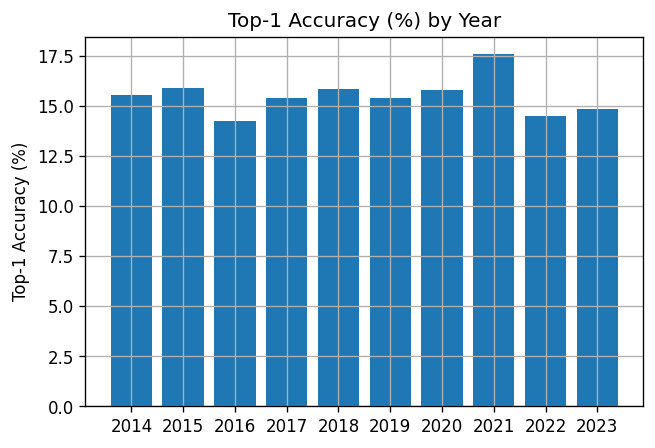

In [28]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['top1']*100)
ax.set_ylabel('Top‑1 Accuracy (%)')
ax.set_title('Top‑1 Accuracy (%) by Year')
plt.show()


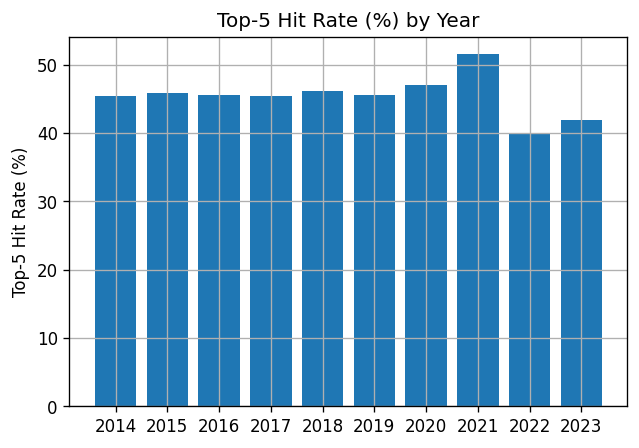

In [29]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['hit5']*100)
ax.set_ylabel('Top‑5 Hit Rate (%)')
ax.set_title('Top‑5 Hit Rate (%) by Year')
plt.show()


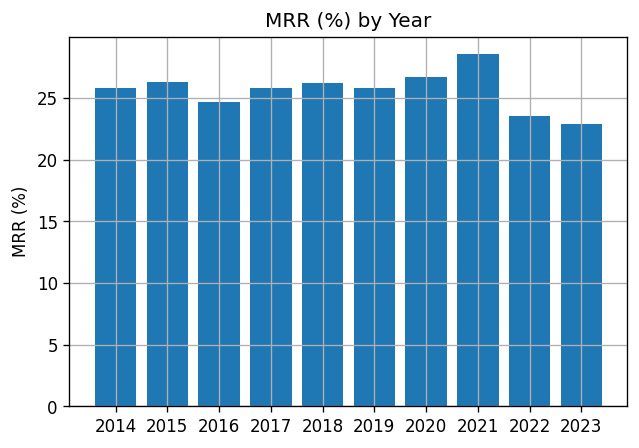

In [30]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['mrr']*100)
ax.set_ylabel('MRR (%)')
ax.set_title('MRR (%) by Year')
plt.show()


### 3.1 Coverage breakdown

In [31]:
unique_pred_poi = (
    pd.Series([poi for preds in df_all["prediction_norm"] for poi in preds])
      .nunique()
)
unique_gt_poi = df_all["ground_truth_norm"].nunique()

print(f"POI distinct in predictions: {unique_pred_poi}")
print(f"POI distinct in ground-truth: {unique_gt_poi}")
print(f"Catalogue Coverage: {unique_pred_poi/unique_gt_poi:.2%}")

POI distinct in predictions: 7846
POI distinct in ground-truth: 22
Catalogue Coverage: 35663.64%


## 4. Error analysis – overview

In questa sezione valutiamo **dove** e **perché** il modello sbaglia, seguendo tre filoni:

1. **Worst-performing POI pairs**  
   Scopriamo quali coppie `ground-truth → first_pred` generano il maggior numero di errori.

2. **Confusion matrix per subset**  
   Heat-map delle frequenze (o tasso d’errore) su un sotto-insieme di POI di interesse
   (ad es. i 20 più visitati o solo l’anno 2020).

3. **Explainability (SHAP / LIME)**  
   Analisi dei fattori testuali nella colonna `history` che portano a una predizione
   sbagliata. Qui mostriamo un prototipo basato su LIME; lo script è modulare
   e può essere sostituito da SHAP se usi modelli compatibili.


,ground_truth_norm,first_pred,errors
273,Castelvecchio,Casa Giulietta,3619
410,Castelvecchio,Duomo,3276
515,Castelvecchio,Palazzo della Ragione,3096
492,Castelvecchio,Museo Miniscalchi,2645
1616,Teatro Romano,Duomo,2108
1544,Teatro Romano,Casa Giulietta,2046
613,Duomo,Casa Giulietta,1993
1949,Torre Lamberti,Casa Giulietta,1973
22,Arena,Casa Giulietta,1869
2076,Torre Lamberti,Palazzo della Ragione,1863


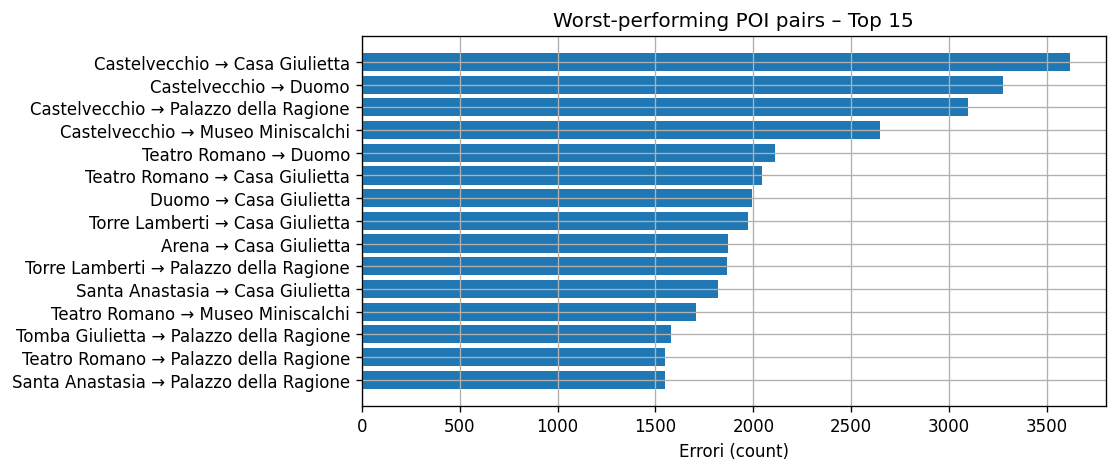

In [32]:
# ---------------------------------------------------------------------
# 4.1 Worst-performing POI pairs (Top-N) – FIX
# ---------------------------------------------------------------------
# filtro righe con errore Top-1
ERR = df_all.assign(first_pred=df_all["prediction_norm"].str[0])
ERR = ERR[~ERR["hit@1"]]           # equivalente a query("`hit@1` == False")

# conteggia coppie ground-truth → first_pred
pairs = (
    ERR.groupby(["ground_truth_norm", "first_pred"])
        .size()
        .reset_index(name="errors")
        .sort_values("errors", ascending=False)
        .head(15)          # Top-15 coppie
)

display(pairs)

# barplot (opzionale)
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(
    pairs.apply(lambda r: f"{r['ground_truth_norm']} → {r['first_pred']}", axis=1),
    pairs["errors"]
)
ax.set_xlabel("Errori (count)")
ax.set_title("Worst-performing POI pairs – Top 15")
ax.invert_yaxis()
plt.show()


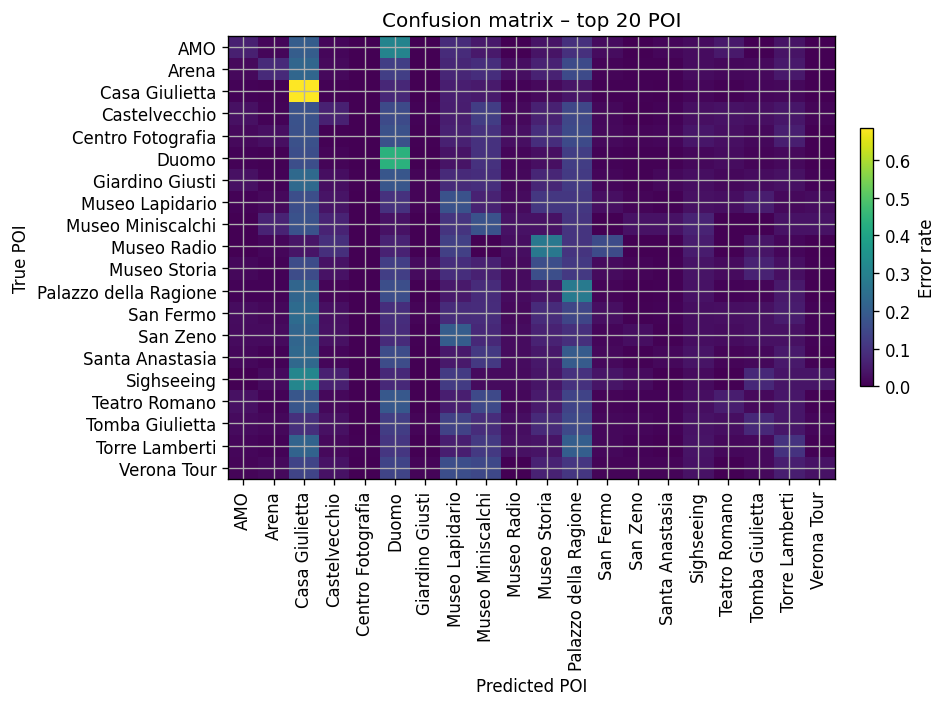

In [33]:
# ---------------------------------------------------------------------
# 4.2 Confusion matrix – seleziona subset
# ---------------------------------------------------------------------
TOP_K = 20          # limitiamoci ai 20 POI più frequenti (ground-truth)
YEAR  = None        # imposta un anno (es. 2020) oppure None per all

subset = df_all.copy()
if YEAR is not None:
    subset = subset.query("year == @YEAR")

# filtra i POI più frequenti
top_poi = (
    subset["ground_truth_norm"]
           .value_counts()
           .head(TOP_K)
           .index
)
mask = subset["ground_truth_norm"].isin(top_poi) & subset["prediction_norm"].str[0].isin(top_poi)
cm_df = pd.crosstab(
    subset.loc[mask, "ground_truth_norm"],
    subset.loc[mask, "prediction_norm"].str[0],
    rownames=["True"],
    colnames=["Pred"],
    dropna=False
)

# Normalizza su righe per avere tassi d’errore
cm_norm = cm_df.div(cm_df.sum(axis=1), axis=0)

# Heat-map (matplotlib only)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm_norm.values, aspect="auto")
ax.set_xticks(range(len(cm_norm.columns)))
ax.set_xticklabels(cm_norm.columns, rotation=90)
ax.set_yticks(range(len(cm_norm.index)))
ax.set_yticklabels(cm_norm.index)
ax.set_xlabel("Predicted POI")
ax.set_ylabel("True POI")
ax.set_title(f"Confusion matrix – top {TOP_K} POI" + (f", year {YEAR}" if YEAR else ""))
fig.colorbar(im, ax=ax, fraction=0.02, pad=0.04, label="Error rate")
plt.tight_layout()
plt.show()


In [37]:
# ---------------------------------------------------------------------
# 4.3 Explainability 
# ---------------------------------------------------------------------
import warnings, json, numpy as np, pandas as pd
from collections import Counter
import re

print("="*60)
print("ERROR ANALYSIS - Simplified Version (No LIME required)")
print("="*60)

# ---------------------------------------------------------------------
# Analisi dei pattern testuali negli errori
# ---------------------------------------------------------------------
err_rows = df_all[~df_all["hit@1"]].copy()
correct_rows = df_all[df_all["hit@1"]].copy()

if err_rows.empty:
    print("🎉 Nessun errore Top-1 da analizzare!")
else:
    print(f"📊 Analyzing {len(err_rows):,} prediction errors vs {len(correct_rows):,} correct predictions")
    
    # Aggiungi colonne per l'analisi
    err_rows['first_pred'] = err_rows["prediction_norm"].str[0]
    correct_rows['first_pred'] = correct_rows["prediction_norm"].str[0]
    
    # ---------------------------------------------------------------------
    # 1. Analisi lunghezza history
    # ---------------------------------------------------------------------
    print("\n1️⃣ HISTORY LENGTH ANALYSIS")
    print("-" * 40)
    
    err_rows['history_length'] = err_rows['history'].astype(str).str.len()
    correct_rows['history_length'] = correct_rows['history'].astype(str).str.len()
    
    print(f"Average history length in ERRORS: {err_rows['history_length'].mean():.0f} chars")
    print(f"Average history length in CORRECT: {correct_rows['history_length'].mean():.0f} chars")
    
    # ---------------------------------------------------------------------
    # 2. Analisi parole chiave più frequenti negli errori
    # ---------------------------------------------------------------------
    print("\n2️⃣ KEYWORD ANALYSIS IN ERROR CASES")
    print("-" * 40)
    
    def extract_keywords(text, min_length=3):
        """Estrae parole significative dal testo"""
        if pd.isna(text):
            return []
        # Rimuovi caratteri speciali e converti in lowercase
        words = re.findall(r'\b[a-zA-ZÀ-ÿ]+\b', str(text).lower())
        # Filtra parole troppo corte e comuni
        stop_words = {'and', 'the', 'poi', 'via', 'del', 'dei', 'per', 'con', 'una', 'uno', 'che', 'nel', 'sul'}
        return [w for w in words if len(w) >= min_length and w not in stop_words]
    
    # Estrai keywords dalle history degli errori
    error_keywords = []
    for history in err_rows['history'].head(1000):  # Limita per performance
        error_keywords.extend(extract_keywords(history))
    
    # Estrai keywords dalle history corrette
    correct_keywords = []
    for history in correct_rows['history'].head(1000):  # Limita per performance
        correct_keywords.extend(extract_keywords(history))
    
    error_word_freq = Counter(error_keywords).most_common(15)
    correct_word_freq = Counter(correct_keywords).most_common(15)
    
    print("Most frequent words in ERROR cases:")
    for word, freq in error_word_freq:
        print(f"  {word:>15s}: {freq:>4d}")
    
    print("\nMost frequent words in CORRECT cases:")
    for word, freq in correct_word_freq:
        print(f"  {word:>15s}: {freq:>4d}")
    
    # ---------------------------------------------------------------------
    # 3. Analisi dei POI più problematici
    # ---------------------------------------------------------------------
    print("\n3️⃣ MOST PROBLEMATIC POI (Ground Truth)")
    print("-" * 40)
    
    # POI con più errori
    error_by_true_poi = (
        err_rows['ground_truth_norm']
        .value_counts()
        .head(10)
        .reset_index()
    )
    error_by_true_poi.columns = ['POI', 'Error_Count']
    
    # Calcola anche il tasso di errore
    total_by_poi = df_all['ground_truth_norm'].value_counts()
    error_by_true_poi['Total_Count'] = error_by_true_poi['POI'].map(total_by_poi)
    error_by_true_poi['Error_Rate'] = error_by_true_poi['Error_Count'] / error_by_true_poi['Total_Count']
    
    print("POI with highest error counts:")
    for _, row in error_by_true_poi.iterrows():
        print(f"  {row['POI']:>25s}: {row['Error_Count']:>3d} errors ({row['Error_Rate']:>5.1%} rate)")
    
    # ---------------------------------------------------------------------
    # 4. Analisi delle predizioni più frequenti negli errori
    # ---------------------------------------------------------------------
    print("\n4️⃣ MOST FREQUENT WRONG PREDICTIONS")
    print("-" * 40)
    
    wrong_pred_freq = err_rows['first_pred'].value_counts().head(10)
    print("Most frequently predicted (wrong) POI:")
    for poi, freq in wrong_pred_freq.items():
        print(f"  {poi:>25s}: {freq:>3d} times")
    
    # ---------------------------------------------------------------------
    # 5. Esempio dettagliato di errore
    # ---------------------------------------------------------------------
    print("\n5️⃣ DETAILED ERROR EXAMPLE")
    print("-" * 40)
    
    # Prendi il primo errore disponibile
    sample_idx = err_rows.index[0]
    sample = df_all.loc[sample_idx]
    
    print(f"Card ID: {sample.get('card_id', 'N/A')}")
    print(f"Year: {sample.get('year', 'N/A')}")
    print(f"True POI: {sample['ground_truth_norm']}")
    print(f"Predicted POI: {sample['prediction_norm'][0]}")
    print(f"Top-5 Predictions: {sample['prediction_norm']}")
    print(f"History (first 200 chars): {str(sample['history'])[:200]}...")
    
    # ---------------------------------------------------------------------
    # 6. Matrice di confusione semplificata (top POI)
    # ---------------------------------------------------------------------
    print("\n6️⃣ CONFUSION MATRIX - TOP 10 POI")
    print("-" * 40)
    
    # Prendi i 10 POI più frequenti
    top_poi = df_all['ground_truth_norm'].value_counts().head(10).index.tolist()
    
    # Filtra solo le predizioni che coinvolgono questi POI
    confusion_data = df_all[
        (df_all['ground_truth_norm'].isin(top_poi)) & 
        (df_all['prediction_norm'].str[0].isin(top_poi))
    ].copy()
    
    confusion_matrix = pd.crosstab(
        confusion_data['ground_truth_norm'],
        confusion_data['prediction_norm'].str[0],
        normalize='index'  # Normalizza per righe (% di errore per POI)
    )
    
    print("Confusion matrix (% of predictions for each true POI):")
    print("Rows = True POI, Columns = Predicted POI")
    print(confusion_matrix.round(3))
    
    # ---------------------------------------------------------------------
    # 7. Summary statistiche
    # ---------------------------------------------------------------------
    print(f"\n7️⃣ SUMMARY STATISTICS")
    print("-" * 40)
    print(f"Total predictions analyzed: {len(df_all):,}")
    print(f"Total errors (Top-1): {len(err_rows):,} ({len(err_rows)/len(df_all):.2%})")
    print(f"Unique POI in dataset: {df_all['ground_truth_norm'].nunique():,}")
    print(f"Unique POI in predictions: {len({poi for preds in df_all['prediction_norm'] for poi in preds}):,}")
    
    if len(csv_files) > 1:
        error_by_year = df_all.groupby('year')['hit@1'].agg(['count', 'mean']).reset_index()
        error_by_year['error_rate'] = 1 - error_by_year['mean']
        print(f"\nError rate by year:")
        for _, row in error_by_year.iterrows():
            if not pd.isna(row['year']):
                print(f"  {int(row['year'])}: {row['error_rate']:.2%} ({int(row['count'])} predictions)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("This analysis doesn't require LIME but provides valuable insights into prediction errors.")
print("="*60)

ERROR ANALYSIS - Simplified Version (No LIME required)
📊 Analyzing 101,084 prediction errors vs 18,636 correct predictions

1️⃣ HISTORY LENGTH ANALYSIS
----------------------------------------
Average history length in ERRORS: 49 chars
Average history length in CORRECT: 48 chars

2️⃣ KEYWORD ANALYSIS IN ERROR CASES
----------------------------------------
Most frequent words in ERROR cases:
            arena:  781
        giulietta:  669
             casa:  570
            torre:  456
         lamberti:  456
            santa:  377
        anastasia:  377
              san:  304
    castelvecchio:  288
            duomo:  265
            fermo:  172
          palazzo:  146
            della:  146
          ragione:  146
             zeno:  132

Most frequent words in CORRECT cases:
            arena:  759
        giulietta:  573
             casa:  489
            torre:  412
         lamberti:  412
    castelvecchio:  295
            santa:  248
        anastasia:  248
              s